<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/Text_procesing_using_RNN_and_CNN_Writer_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files   # module for file uploading into colab
import numpy as np               # library to operate the data arrays
import pandas as pd              # library for data processing and analyzing
import matplotlib.pyplot as plt  # library for data visualization
import os                        # for working with the file system
# to start the library in the notebook
%matplotlib inline

from tensorflow.keras import utils # The module with Keras utilities will be used to call the method of converting categories into vectorsfrom tensorflow.keras
from tensorflow.keras.models import Sequential # sequental model of keras neural network
# loading the standard layers of a neural network (dense, regularization, normalization, word embedding, flatten, activation)
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation
# loading the convolutional layers
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
# loading the recurrent layers
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional
# loading the training/optimization algorithms
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence  # Keras tools for text pre-processing
from sklearn.model_selection import train_test_split                   # a module for data splitting into training and testing

In [ ]:
!rm -R /content/texts # the folder texts is deleted, if any;

rm: cannot remove '/content/texts': No such file or directory


**Loading of data and splitting into words.**

In [ ]:
# указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Тексты писателей.zip' -d /content/texts

In [ ]:
def readText(fileName):          # declaring the functions to read the file, a file path is sent to the input
  f = open(fileName, 'r')        # initiating the opening of the relevant file in read-only mode
  text = f.read()                # text reading
  text = text.replace("\n", " ") # converting the line breaks into spaces

  return text                    # file text returning

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # объявляем интересующие нас классы
nClasses = len(className)                                                         # считаем количество классов

In [ ]:
# loading the training texts

trainText = []  # формируем обучающие тексты
testText = []   # формируем тестовые тексты

# формирование необходимо произвести следующим образом:
# класс каждого i-ого эллемента в обучающей выборке должен соответствовать
# классу каждого i-ого эллемента в тестовой выборке

for i in className:              # проходим по каждому классу
  for j in os.listdir('texts/'): # проходим по каждому файлу в папке с текстами
    if i in j:                   # проверяем, содержит ли файл j в названии имя класса i

      if 'Обучающая' in j:                       # если в имени найденного класса есть строка "Обучающая"
        trainText.append(readText('texts/' + j)) # добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') # выводим информацию
      if 'Тестовая' in j:                        # если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j))  # добавляем в тестовую выборку
        print(j, 'добавлен в тестовую выборку')  # выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
print(len(trainText))    # total elements in trainText
print(len(trainText[0])) # total symbols in the first source in trainText

6
1049517


**Creating the glossary and transforming the data into indices.**

In [ ]:
maxWordsCount = 20000 # определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
# num_words=maxWordsCount - определяем максимальное количество слов/индексов, учитываемое при обучении текстов
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' - избавляемся от ненужных символов
# lower=True - приводим слова к нижнему регистру
# split=' ' - разделяем слова по пробелу
# char_level=False - просим токенайзер не удалять однобуквенные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)

tokenizer.fit_on_texts(trainText)          # даём тексты в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # вытаскиваем индексы слов для просмотра

In [ ]:
# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тексты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тексты в индексы

print("Взглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[0][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[1][:20], '\n')

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               «Лиса-на-рассвете»   Коралио нежился в полуденном зное, как томная красавица в сурово х
Он же в виде последовательности индексов:  [473, 22, 1, 1508, 47, 2, 12834, 7800, 5, 415, 1, 4, 251, 2, 4, 249, 55, 6, 240, 9472] 



In [ ]:
print(len(trainWordIndexes))    # количество элементов в trainText
print(len(trainWordIndexes[0]))

6
160607


** Data conversion into training sample.**

1.   List item
2.   List item



In [ ]:
# формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)

def getSetFromIndexes(wordIndexes, xLen, step):
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  # идём по всей длине вектора индексов
  # "откусываем" векторы длины xLen и смещаемся вперёд на step

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step

  return xSample

In [ ]:
# формирование обучающей и проверочной выборки
# из двух листов индексов от двух классов

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # для каждого из 6 классов создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна"

  # формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"

  for t in range(nClasses):   # в диапазоне кол-ва классов (6)
    xT = classesXSamples[t]   # берем очередной текст вида "кол-во окон в тексте*длину окна" (например, 1341*1000)
    for i in range(len(xT)):  # и каждое его окно
      xSamples.append(xT[i])  # добавляем в общий список выборки

    # формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)):  # на каждое окно выборки
      ySamples.append(currY)  # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

In [ ]:
# задаём базовые параметры
xLen = 1000 # длина отрезка текста, по которой анализируем, в словах
step = 100  # шаг разбиения исходного текста на обучающие вектора

In [ ]:
# формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)
# получили обучающий/тестовый набор, достаточный для запуска Embedding,
# но для Bag of Words нужно xTrain и xTest представить в виде векторов из 0 и 1

(17640, 1000)
(17640, 6)
(6686, 1000)
(6686, 6)


**Embedding + Dense NN**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 86s 302ms/step - accuracy: 0.6939 - loss: 1.0932 - val_accuracy: 0.3301 - val_loss: 2.0140
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 138s 289ms/step - accuracy: 0.9978 - loss: 0.0090 - val_accuracy: 0.5182 - val_loss: 1.6988
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 292ms/step - accuracy: 0.9988 - loss: 0.0041 - val_accuracy: 0.6784 - val_loss: 1.2901
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 290ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.6877 - val_loss: 1.2175
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 292ms/step - accuracy: 0.9982 - loss: 0.0064 - val_accuracy: 0.6741 - val_loss: 1.4114
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 80s 291ms/step - accuracy: 0.9986 - loss: 0.0042 - val_accuracy: 0.6714 - val_loss: 1.5719
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.9992 - loss: 0.0035 - val_accuracy: 0.6466 - val_loss: 1.9871
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 89s 310ms/step - accuracy: 0.9987 - loss: 

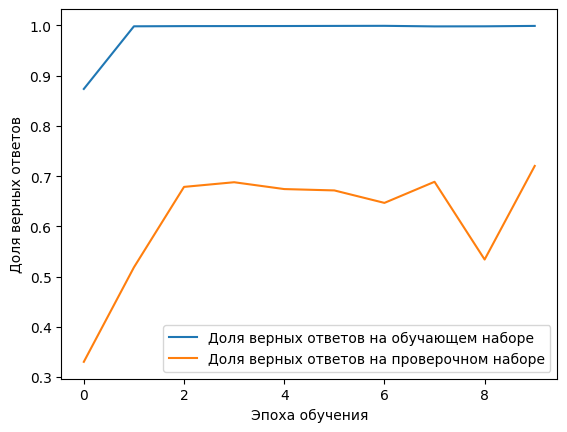

In [ ]:
modelED = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelED.add(Embedding(maxWordsCount, 50, input_length=xLen))
modelED.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelED.add(Flatten())
modelED.add(BatchNormalization())  # добавляем слой нормализации данных
modelED.add(Dense(200, activation="relu"))  # добавляем полносвязный слой
modelED.add(Dropout(0.2))
modelED.add(BatchNormalization())
modelED.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelED.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelED.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

**Embedding + LSTM NN **

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 239s 851ms/step - accuracy: 0.7831 - loss: 0.5822 - val_accuracy: 0.3916 - val_loss: 2.0269
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 262s 851ms/step - accuracy: 0.9829 - loss: 0.0552 - val_accuracy: 0.5655 - val_loss: 1.6522
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 259s 843ms/step - accuracy: 0.9876 - loss: 0.0426 - val_accuracy: 0.4106 - val_loss: 3.9515
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 265s 855ms/step - accuracy: 0.9897 - loss: 0.0379 - val_accuracy: 0.5736 - val_loss: 1.7877
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 234s 849ms/step - accuracy: 0.9927 - loss: 0.0338 - val_accuracy: 0.6946 - val_loss: 1.0897
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 263s 853ms/step - accuracy: 0.9932 - loss: 0.0207 - val_accuracy: 0.5863 - val_loss: 1.7993
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 239s 865ms/step - accuracy: 0.9933 - loss: 0.0264 - val_accuracy: 0.5606 - val_loss: 1.9694
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 235s 853ms/step - accuracy: 0.9949 -

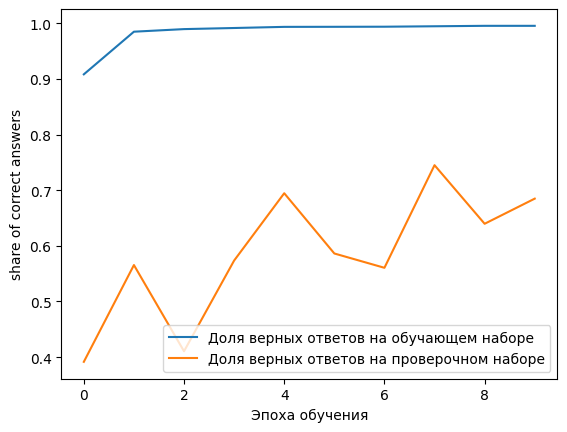

In [ ]:
modelEL = Sequential() # создаём последовательную модель нейросети

# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEL.add(Embedding(maxWordsCount, 10, input_length=xLen))

modelEL.add(SpatialDropout1D(0.2)) # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEL.add(BatchNormalization())  # добавляем слой нормализации данных
modelEL.add(LSTM(8, return_sequences=True))
modelEL.add(LSTM(8, return_sequences=True))
modelEL.add(Flatten())
modelEL.add(Dense(6, activation='softmax')) # добавляем полносвязный слой на 6 нейронов с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEL.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelEL.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('share of correct answers')
plt.legend()
plt.show()


**Embedding + Conv1D NN**

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 80s 281ms/step - accuracy: 0.6084 - loss: 1.1656 - val_accuracy: 0.2930 - val_loss: 5.0791
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 277ms/step - accuracy: 0.9954 - loss: 0.0163 - val_accuracy: 0.4144 - val_loss: 6.8983
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 294ms/step - accuracy: 0.9949 - loss: 0.0179 - val_accuracy: 0.5645 - val_loss: 3.3616
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 278ms/step - accuracy: 0.9950 - loss: 0.0170 - val_accuracy: 0.5582 - val_loss: 4.2782
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 84s 283ms/step - accuracy: 0.9954 - loss: 0.0162 - val_accuracy: 0.6392 - val_loss: 3.2124
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 82s 284ms/step - accuracy: 0.9958 - loss: 0.0167 - val_accuracy: 0.6461 - val_loss: 2.5311
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 77s 278ms/step - accuracy: 0.9964 - loss: 0.0145 - val_accuracy: 0.5165 - val_loss: 6.3517
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 84s 305ms/step - accuracy: 0.9959 - loss: 0

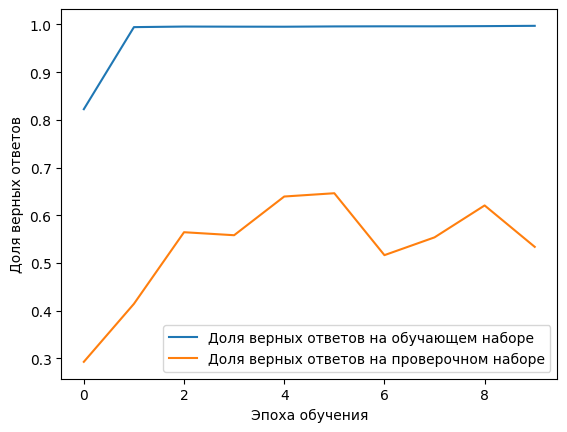

In [ ]:
modelEC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEC.add(Embedding(maxWordsCount, 30, input_length=xLen))

modelEC.add(SpatialDropout1D(0.2))            # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEC.add(BatchNormalization())             # добавляем слой нормализации данных
modelEC.add(Conv1D(30, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(Conv1D(30, 5, activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEC.add(MaxPooling1D(2))                  # добавляем слой подвыборки/пулинга с функцией максимума
modelEC.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEC.add(BatchNormalization())             # добавляем слой нормализации данных
modelEC.add(Flatten())                        # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEC.add(Dense(6, activation='softmax'))   # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelEC.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


**Embedding + complex NN of Dense, LSTM и Conv1D**

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 144s 502ms/step - accuracy: 0.6116 - loss: 1.2925 - val_accuracy: 0.2351 - val_loss: 5.8443
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 136s 491ms/step - accuracy: 0.9937 - loss: 0.0219 - val_accuracy: 0.4502 - val_loss: 4.2205
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 142s 514ms/step - accuracy: 0.9943 - loss: 0.0204 - val_accuracy: 0.6615 - val_loss: 1.7841
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 141s 511ms/step - accuracy: 0.9959 - loss: 0.0140 - val_accuracy: 0.6828 - val_loss: 1.7334
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 139s 502ms/step - accuracy: 0.9953 - loss: 0.0137 - val_accuracy: 0.6092 - val_loss: 2.6029
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 139s 504ms/step - accuracy: 0.9961 - loss: 0.0122 - val_accuracy: 0.7356 - val_loss: 1.4697
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 144s 511ms/step - accuracy: 0.9970 - loss: 0.0107 - val_accuracy: 0.7613 - val_loss: 1.4188
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 139s 501ms/step - accuracy: 0.9975 -

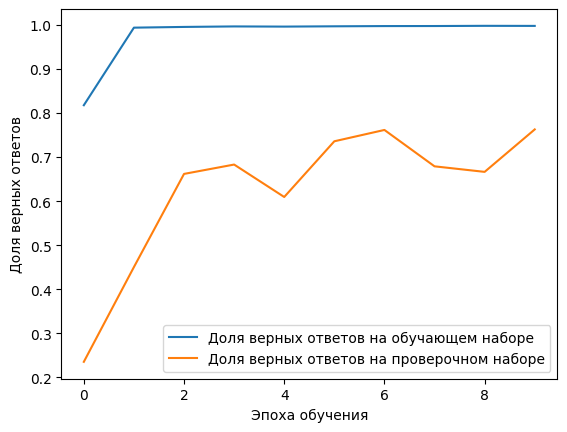

In [ ]:
modelEDLC = Sequential() # создаём последовательную модель нейросети
# преобразовываем каждое слово в многомерный вектор c указанием размерности вектора и длины входных данных
modelEDLC.add(Embedding(maxWordsCount, 50, input_length=xLen))

modelEDLC.add(SpatialDropout1D(0.2))            # добавляем слой регуляризации, "выключая" 1D карты объектов из эмбединг векторов, во избежание переобучения
modelEDLC.add(Conv1D(64, 3, padding='same', activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEDLC.add(MaxPooling1D(2))
modelEDLC.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEDLC.add(BatchNormalization())             # добавляем слой нормализации данных
modelEDLC.add(Conv1D(64, 3, padding='same', activation="relu"))
modelEDLC.add(MaxPooling1D(2))                  # добавляем слой подвыборки/пулинга с функцией максимума
modelEDLC.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEDLC.add(BatchNormalization())             # добавляем слой нормализации данных
modelEDLC.add(Conv1D(64, 3, padding='same', activation="relu")) # добавляем одномерный сверточный слой, указывая кол-во фильтров и ширину окна для фильтров
modelEDLC.add(MaxPooling1D(2))
modelEDLC.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEDLC.add(BatchNormalization())             # добавляем слой нормализации данных
modelEDLC.add(LSTM(8, return_sequences=1))      # добавляем слой LSTM, совместимый с Cuda при поддержке GPU
modelEDLC.add(Dropout(0.2))                     # добавляем слой регуляризации, "выключая" указанное количество нейронов, во избежание переобучения
modelEDLC.add(BatchNormalization())             # добавляем слой нормализации данных
modelEDLC.add(Dense(256, activation='relu'))    # добавляем полносвязный слой с указанием количества нейронов и функции активации
modelEDLC.add(Dropout(0.2))
modelEDLC.add(Flatten())                        # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
modelEDLC.add(Dense(6, activation='softmax'))   # добавляем полносвязный слой на 6 нейронов, с функцией активации softmax на выходном слое

# компиляция, составление модели с выбором алгоритма оптимизации, функции потерь и метрики точности
modelEDLC.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# обучаем сеть с указанием тренировочной выборки, количества эпох, размера минибатча для подачи сети и тестовой выборки
history = modelEDLC.fit(xTrain,
                    yTrain,
                    epochs=10,
                    batch_size=64,
                    validation_data=(xTest, yTest))

# строим график для отображения динамики обучения и точности предсказания сети
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()
